## Импорт необходимых библиотек

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu,ttest_ind, kruskal,chisquare, pearsonr, spearmanr
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu,ttest_ind, kruskal,chisquare, pearsonr, spearmanr
import os
!pip install h2o
import h2o
h2o.init()
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2OIsolationForestEstimator
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators import H2OSupportVectorMachineEstimator
from h2o.grid.grid_search import H2OGridSearch




/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



     |████████████████████████████████| 67.3MB 107kB/s 
     |████████████████████████████████| 164.8MB 86kB/s 
  Created wheel for h2o: filename=h2o-3.32.1.1-py2.py3-none-any.whl size=164840229 sha256=a4d1c55eea058269d4e3b08a04aebd40d3e5d7173295df6cbcbf0ccb9f2e84bd
  Stored in directory: /root/.cache/pip/wheels/4d/94/84/02ea21db1eebcef2da872861ce0db478788e27d24bcd5394fb
Successfully built h2o
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.10" 2021-01-19; OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpy87l0h70
  JVM stdout: /tmp/tmpy87l0h70/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpy87l0h70/h2o_unknownUser_started_from_python.err
  

H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,6 days
H2O_cluster_name:,H2O_from_python_unknownUser_ibrg50
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


# Читаем данные

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DATA_SETS/prep_filled_1.csv')
df = df.drop('Unnamed: 0', axis=1)
df.columns

Index(['Bensilpenicillin', 'Norfloxacin', 'Tetracycline', 'Erythromicine',
       'Teicoplanine', 'Oxiciline', 'Cluster', 'Max_Platlets', 'Max_ESR',
       'Max_Fibrinogen', 'Max_LDH', 'Max_Leucocytes', 'Hemoglobin',
       'Max_Creatinine', 'Min_Cratinine', 'Gender', 'initial_CRP', 'Max_CRP',
       'Treatment', 'Diagnosis_y', 'Pneumonia', 'Severity', 'IHD', 'COPD',
       'Bronchial_asthma', 'Obesity', 'Diabetes', 'RF_y', 'ALT', 'AST',
       'Ab_ind', 'duration', 'Age', 'GFR'],
      dtype='object')

## Определение анализируемых данных, чистка данных

In [ ]:
data=df[[ 'Norfloxacin',  'Max_Platlets', 'Max_ESR',
       'Max_Fibrinogen', 'Max_Leucocytes', 
       'Gender',  'Max_CRP',
        'Pneumonia', 'Severity', 'IHD', 'COPD',
       'Bronchial_asthma', 'Obesity', 'Diabetes', 'RF_y', 'ALT', 'AST',
       'Age']]
data['Gender'] = data['Gender'].map({'male':1, 'female':0})
data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)].astype('float16')
data = h2o.H2OFrame(data)

In [ ]:
predictors = ['Max_Platlets', 'Max_ESR',
       'Max_Fibrinogen', 'Max_Leucocytes', 
       'Gender',  
        'Pneumonia', 'Severity', 'IHD', 'COPD'
        ,
       'Bronchial_asthma', 'Obesity', 'Diabetes', 'RF_y',
       'Age'] # определяем признаки, которые будут использоваться в качестве предсказателей
 # убираем из этого списка целевую - "Norfloxacin"
data['Norfloxacin'] = data['Norfloxacin'].asfactor() # определяем "Norfloxacin" как фактор, который нужно предсказать
train, test = data.split_frame(seed = 42, ratios = [.8])
target = 'Norfloxacin'

In [ ]:
# Запускаем AutoML, 20 моделей
aml = H2OAutoML(max_models=20, nfolds=5,
                 seed=123, balance_classes=True)
aml.train(x = predictors,
           y = target,
           training_frame = train)


Проверяем качество лидера на тестовых данных

In [ ]:
aml.leader.model_performance(test)


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2262540349470216
RMSE: 0.47566168118424423
LogLoss: 0.9307772981325856
Mean Per-Class Error: 0.19871794871794868
AUC: 0.7307692307692307
AUCPR: 0.650681357697235
Gini: 0.46153846153846145

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.033315952128429825: 


,,0,1,Error,Rate
0,0,10.0,3.0,0.2308,(3.0/13.0)
1,1,1.0,5.0,0.1667,(1.0/6.0)
2,Total,11.0,8.0,0.2105,(4.0/19.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.033316,0.714286,7.0
1,max f2,0.033316,0.781250,7.0
2,max f0point5,0.887281,0.714286,1.0
3,max accuracy,0.887281,0.789474,1.0
4,max precision,0.998445,1.000000,0.0
5,max recall,0.000260,1.000000,17.0
6,max specificity,0.998445,1.000000,0.0
7,max absolute_mcc,0.033316,0.567295,7.0
8,max min_per_class_accuracy,0.033316,0.769231,7.0
9,max mean_per_class_accuracy,0.033316,0.801282,7.0



Gains/Lift Table: Avg response rate: 31.58 %, avg score: 23.89 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.052632,0.978435,3.166667,3.166667,1.0,0.998445,1.000000,0.998445,0.166667,0.166667,216.666667,216.666667,0.166667
1,2,0.052632,0.958426,0.000000,3.166667,0.0,0.000000,1.000000,0.998445,0.000000,0.166667,-100.000000,216.666667,0.166667
2,3,0.052632,0.938416,0.000000,3.166667,0.0,0.000000,1.000000,0.998445,0.000000,0.166667,-100.000000,216.666667,0.166667
3,4,0.052632,0.918407,0.000000,3.166667,0.0,0.000000,1.000000,0.998445,0.000000,0.166667,-100.000000,216.666667,0.166667
4,5,0.052632,0.898397,0.000000,3.166667,0.0,0.000000,1.000000,0.998445,0.000000,0.166667,-100.000000,216.666667,0.166667
5,6,0.105263,0.776250,3.166667,3.166667,1.0,0.887281,1.000000,0.942863,0.166667,0.333333,216.666667,216.666667,0.333333
6,7,0.157895,0.664471,0.000000,2.111111,0.0,0.748492,0.666667,0.878073,0.000000,0.333333,-100.000000,111.111111,0.256410
7,8,0.210526,0.620690,0.000000,1.583333,0.0,0.628462,0.500000,0.815670,0.000000,0.333333,-100.000000,58.333333,0.179487
8,9,0.315789,0.302929,1.583333,1.583333,0.5,0.485524,0.500000,0.705622,0.166667,0.500000,58.333333,58.333333,0.269231
9,10,0.421053,0.029918,3.166667,1.979167,1.0,0.128664,0.625000,0.561382,0.333333,0.833333,216.666667,97.916667,0.602564


In [ ]:
# model_path = h2o.save_model(model=aml.leader, path="/content/drive/MyDrive/DATA_SETS", force=True)

In [ ]:
aml.leader.model_performance(train)


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.06543574789685996
RMSE: 0.25580412017178294
LogLoss: 0.19005748546601728
Mean Per-Class Error: 0.040322580645161255
AUC: 0.9917114695340502
AUCPR: 0.9863795277196866
Gini: 0.9834229390681004

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05735391735035158: 


,,0,1,Error,Rate
0,0,57.0,5.0,0.0806,(5.0/62.0)
1,1,0.0,36.0,0.0,(0.0/36.0)
2,Total,57.0,41.0,0.051,(5.0/98.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,5.735392e-02,0.935065,36.0
1,max f2,5.735392e-02,0.972973,36.0
2,max f0point5,2.511532e-01,0.961538,29.0
3,max accuracy,5.735392e-02,0.948980,36.0
4,max precision,9.999998e-01,1.000000,0.0
5,max recall,5.735392e-02,1.000000,36.0
6,max specificity,9.999998e-01,1.000000,0.0
7,max absolute_mcc,5.735392e-02,0.898464,36.0
8,max min_per_class_accuracy,1.339127e-01,0.935484,33.0
9,max mean_per_class_accuracy,5.735392e-02,0.959677,36.0



Gains/Lift Table: Avg response rate: 36.73 %, avg score: 29.25 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010204,9.999741e-01,2.722222,2.722222,1.000000,1.000000,1.000000,1.000000,0.027778,0.027778,172.222222,172.222222,0.027778
1,2,0.020408,9.999499e-01,2.722222,2.722222,1.000000,0.999973,1.000000,0.999987,0.027778,0.055556,172.222222,172.222222,0.055556
2,3,0.030612,9.998908e-01,2.722222,2.722222,1.000000,0.999948,1.000000,0.999974,0.027778,0.083333,172.222222,172.222222,0.083333
3,4,0.040816,9.998019e-01,2.722222,2.722222,1.000000,0.999885,1.000000,0.999952,0.027778,0.111111,172.222222,172.222222,0.111111
4,5,0.051020,9.995990e-01,2.722222,2.722222,1.000000,0.999791,1.000000,0.999919,0.027778,0.138889,172.222222,172.222222,0.138889
5,6,0.102041,9.964992e-01,2.722222,2.722222,1.000000,0.998622,1.000000,0.999271,0.138889,0.277778,172.222222,172.222222,0.277778
6,7,0.153061,9.917605e-01,2.722222,2.722222,1.000000,0.994686,1.000000,0.997743,0.138889,0.416667,172.222222,172.222222,0.416667
7,8,0.204082,9.826200e-01,2.722222,2.722222,1.000000,0.988447,1.000000,0.995419,0.138889,0.555556,172.222222,172.222222,0.555556
8,9,0.306122,2.509904e-01,2.722222,2.722222,1.000000,0.651239,1.000000,0.880692,0.277778,0.833333,172.222222,172.222222,0.833333
9,10,0.397959,8.890776e-02,1.209877,2.373219,0.444444,0.194807,0.871795,0.722411,0.111111,0.944444,20.987654,137.321937,0.863799


## Важность признаков, влияющих на таргет

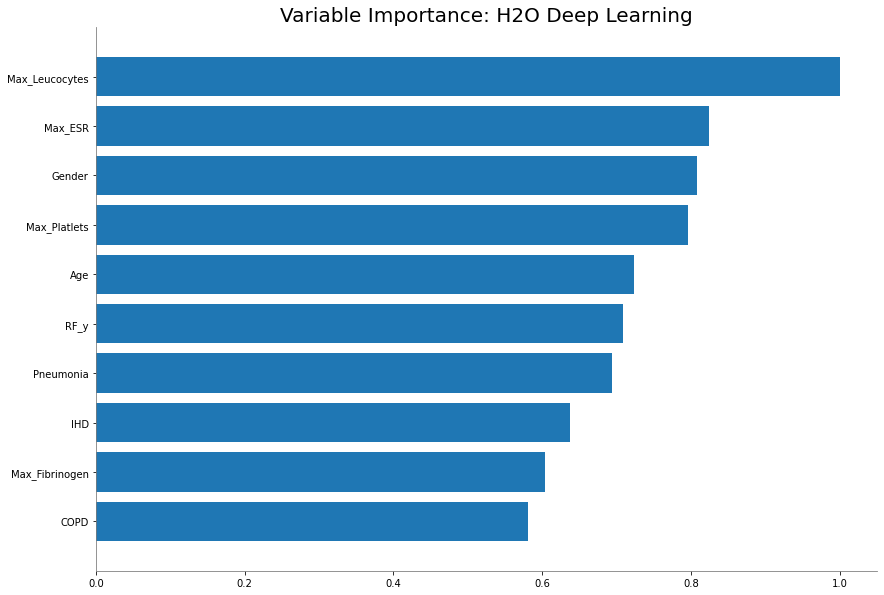

In [ ]:
aml.leader.varimp_plot()

# Архитектура нейронной сети

In [ ]:
aml.leader

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid__1_AutoML_20210320_140545_model_1


Status of Neuron Layers: predicting Norfloxacin, 2-class classification, bernoulli distribution, CrossEntropy loss, 3,402 weights/biases, 46.5 KB, 356,580 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,14,Input,20,,,,,,,,,
1,,2,200,RectifierDropout,10,0,0,0.00851025,0.0174263,0,-0.0139238,0.306446,-0.0927303,0.740404
2,,3,2,Softmax,,0,0,0.0020958,0.000762692,0,-0.0296117,0.404039,-0.000787567,0.212742




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.08217143597675572
RMSE: 0.28665560517240146
LogLoss: 0.2367292980818262
Mean Per-Class Error: 0.040322580645161255
AUC: 0.9916834677419355
AUCPR: 0.9919933512969304
Gini: 0.983366935483871

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05735391735035158: 


,,0,1,Error,Rate
0,0,57.0,5.0,0.0806,(5.0/62.0)
1,1,0.0,64.0,0.0,(0.0/64.0)
2,Total,57.0,69.0,0.0397,(5.0/126.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,5.735392e-02,0.962406,36.0
1,max f2,5.735392e-02,0.984615,36.0
2,max f0point5,2.511532e-01,0.964286,29.0
3,max accuracy,5.735392e-02,0.960317,36.0
4,max precision,9.999998e-01,1.000000,0.0
5,max recall,5.735392e-02,1.000000,36.0
6,max specificity,9.999998e-01,1.000000,0.0
7,max absolute_mcc,5.735392e-02,0.923436,36.0
8,max min_per_class_accuracy,1.339127e-01,0.935484,33.0
9,max mean_per_class_accuracy,5.735392e-02,0.959677,36.0



Gains/Lift Table: Avg response rate: 50.79 %, avg score: 40.97 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.015873,9.999931e-01,1.968750,1.968750,1.000000,1.000000,1.000000,1.000000,0.031250,0.031250,96.875000,96.875000,0.031250
1,2,0.031746,9.999733e-01,1.968750,1.968750,1.000000,0.999973,1.000000,0.999987,0.031250,0.062500,96.875000,96.875000,0.062500
2,3,0.031746,9.999546e-01,0.000000,1.968750,0.000000,0.000000,1.000000,0.999987,0.000000,0.062500,-100.000000,96.875000,0.062500
3,4,0.047619,9.999484e-01,1.968750,1.968750,1.000000,0.999948,1.000000,0.999974,0.031250,0.093750,96.875000,96.875000,0.093750
4,5,0.063492,9.998851e-01,1.968750,1.968750,1.000000,0.999885,1.000000,0.999952,0.031250,0.125000,96.875000,96.875000,0.125000
5,6,0.111111,9.995066e-01,1.968750,1.968750,1.000000,0.999621,1.000000,0.999810,0.093750,0.218750,96.875000,96.875000,0.218750
6,7,0.158730,9.975295e-01,1.968750,1.968750,1.000000,0.998013,1.000000,0.999271,0.093750,0.312500,96.875000,96.875000,0.312500
7,8,0.206349,9.956056e-01,1.968750,1.968750,1.000000,0.995844,1.000000,0.998480,0.093750,0.406250,96.875000,96.875000,0.406250
8,9,0.309524,9.860740e-01,1.968750,1.968750,1.000000,0.989447,1.000000,0.995469,0.203125,0.609375,96.875000,96.875000,0.609375
9,10,0.404762,4.074367e-01,1.968750,1.968750,1.000000,0.769076,1.000000,0.942200,0.187500,0.796875,96.875000,96.875000,0.796875




ModelMetricsBinomial: deeplearning
** Reported on cross-validation data. **

MSE: 0.28827031902945394
RMSE: 0.5369081104150448
LogLoss: 1.05801547439492
Mean Per-Class Error: 0.4193548387096775
AUC: 0.5649641577060932
AUCPR: 0.43061261521060235
Gini: 0.1299283154121864

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.010757053769695752: 


,,0,1,Error,Rate
0,0,9.0,53.0,0.8548,(53.0/62.0)
1,1,1.0,35.0,0.0278,(1.0/36.0)
2,Total,10.0,88.0,0.551,(54.0/98.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.010757,0.564516,87.0
1,max f2,0.010757,0.754310,87.0
2,max f0point5,0.323347,0.468750,38.0
3,max accuracy,0.976123,0.653061,5.0
4,max precision,0.976123,0.666667,5.0
5,max recall,0.000714,1.000000,97.0
6,max specificity,0.999343,0.983871,0.0
7,max absolute_mcc,0.010757,0.186945,87.0
8,max min_per_class_accuracy,0.198895,0.548387,47.0
9,max mean_per_class_accuracy,0.323347,0.580645,38.0



Gains/Lift Table: Avg response rate: 36.73 %, avg score: 29.45 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010204,0.995852,0.000000,0.000000,0.000000,0.999343,0.000000,0.999343,0.000000,0.000000,-100.000000,-100.000000,-0.016129
1,2,0.020408,0.995085,2.722222,1.361111,1.000000,0.995744,0.500000,0.997543,0.027778,0.027778,172.222222,36.111111,0.011649
2,3,0.030612,0.990722,0.000000,0.907407,0.000000,0.995043,0.333333,0.996710,0.000000,0.027778,-100.000000,-9.259259,-0.004480
3,4,0.040816,0.981405,2.722222,1.361111,1.000000,0.990295,0.500000,0.995106,0.027778,0.055556,172.222222,36.111111,0.023297
4,5,0.051020,0.976733,2.722222,1.633333,1.000000,0.980192,0.600000,0.992123,0.027778,0.083333,172.222222,63.333333,0.051075
5,6,0.102041,0.787299,1.088889,1.361111,0.400000,0.910514,0.500000,0.951319,0.055556,0.138889,8.888889,36.111111,0.058244
6,7,0.153061,0.706045,1.633333,1.451852,0.600000,0.760197,0.533333,0.887612,0.083333,0.222222,63.333333,45.185185,0.109319
7,8,0.204082,0.475303,0.544444,1.225000,0.200000,0.576799,0.450000,0.809908,0.027778,0.250000,-45.555556,22.500000,0.072581
8,9,0.306122,0.387810,1.088889,1.179630,0.400000,0.415380,0.433333,0.678399,0.111111,0.361111,8.888889,17.962963,0.086918
9,10,0.397959,0.318850,1.512346,1.256410,0.555556,0.350226,0.461538,0.602667,0.138889,0.500000,51.234568,25.641026,0.161290




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.47894737,0.14400533,0.35,0.5,0.65,0.31578946,0.57894737
1,auc,0.47340658,0.17014551,0.25274727,0.625,0.5416667,0.33333334,0.6142857
2,aucpr,0.401511,0.2438261,0.24644023,0.62600493,0.6973376,0.15127273,0.28649953
3,err,0.52105266,0.14400533,0.65,0.5,0.35,0.68421054,0.42105263
4,err_count,10.2,2.7748873,13.0,10.0,7.0,13.0,8.0
5,f0point5,0.46009827,0.14815173,0.40229884,0.5,0.6818182,0.2777778,0.4385965
6,f1,0.5689209,0.14348078,0.5185185,0.61538464,0.7741935,0.3809524,0.5555556
7,f2,0.7576651,0.10558523,0.7291667,0.8,0.8955224,0.6060606,0.75757575
8,lift_top_group,0.8333333,1.1785113,0.0,2.5,1.6666666,0.0,0.0
9,logloss,1.0588865,0.34812763,1.4467752,0.834143,0.81037676,0.771112,1.4320257



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-03-20 14:07:33,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-03-20 14:07:33,1 min 17.585 sec,9130 obs/sec,10.0,1,1260.0,0.531252,0.901533,-0.129199,0.652218,0.654420,1.96875,0.460317
2,,2021-03-20 14:07:38,1 min 22.645 sec,17000 obs/sec,700.0,70,88200.0,0.329096,0.336659,0.566673,0.970010,0.972576,1.96875,0.095238
3,,2021-03-20 14:07:43,1 min 27.674 sec,19130 obs/sec,1550.0,155,195300.0,0.342249,0.405933,0.531344,0.977319,0.978943,1.96875,0.071429
4,,2021-03-20 14:07:48,1 min 32.733 sec,20646 obs/sec,2500.0,250,315000.0,0.290555,0.247823,0.662227,0.990423,0.990467,1.96875,0.039683
5,,2021-03-20 14:07:50,1 min 34.438 sec,21033 obs/sec,2830.0,283,356580.0,0.286656,0.236729,0.671231,0.991683,0.991993,1.96875,0.039683



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Max_Leucocytes,1.000000,1.000000,0.108318
1,Max_ESR,0.824596,0.824596,0.089319
2,Gender,0.808380,0.808380,0.087562
3,Max_Platlets,0.795621,0.795621,0.086180
4,Age,0.723694,0.723694,0.078389
5,RF_y,0.708491,0.708491,0.076743
6,Pneumonia,0.693650,0.693650,0.075135
7,IHD,0.637342,0.637342,0.069036
8,Max_Fibrinogen,0.604062,0.604062,0.065431
9,COPD,0.581256,0.581256,0.062961


<bound method ModelBase.auc of >

# Статистический анализ

In [ ]:
cols = ['Max_Platlets', 'Max_ESR',
        'Max_Leucocytes', 'Age'
         ]
ab = ['Norfloxacin']

In [ ]:
def Basic_statistics(lst_1, lst_2):
    """ 
    Функция "Базовые статистики"

    На вход получает 2 списка данных для сравнения.
    На выходе получаем p-values, при сравнении признаков. 
    В частности: показаны, не показаны антибиотики
    """
    res_mw = mannwhitneyu(lst_1, lst_2, 
                       use_continuity=True, 
                       alternative=None) # u -тест манна-уитни
    res_kw = kruskal(lst_1, lst_2)## краскела уолиса
    anova = stats.f_oneway(lst_1, lst_2) #тест анова
    return res_mw[1], res_kw[1],  anova[1]


In [ ]:
for ant in ab:
  df_r = data[data[ant] == 1]
  df_s = data[data[ant] == 0]
  for cat in cols:
    lst1 = df_r[cat]
    lst2 = df_s[cat]
    shapiro_test = stats.shapiro(lst1) # тест шапиро-уилка
    shapiro_test2 = stats.shapiro(lst2) # тест шапиро-уилка
    if shapiro_test[1] < .05:
      print('Данные {0} распределены ненормально,\
            p-value - {1}'.format(cat,  shapiro_test[1]))
    if shapiro_test2[1] < .05:
      print('Данные {0} распределены ненормально,\
            p-value - {1}'.format(cat,  shapiro_test2[1]))
    else:
      pass

Данные Max_Platlets распределены ненормально,            p-value - 0.049371086061000824
Данные Max_Platlets распределены ненормально,            p-value - 8.52255155336934e-09
Данные Max_ESR распределены ненормально,            p-value - 0.03123696707189083
Данные Max_ESR распределены ненормально,            p-value - 0.011358648538589478
Данные Max_Leucocytes распределены ненормально,            p-value - 0.008890088647603989
Данные Age распределены ненормально,            p-value - 0.0029696321580559015


In [ ]:
df_r = data[data['Norfloxacin'] == 1]

In [ ]:
df_r['Age'].describe()

count    42.000000
mean     61.562500
std      18.859375
min      18.000000
25%      47.500000
50%      60.000000
75%      79.750000
max      93.000000
Name: Age, dtype: float64

In [ ]:
for ant in ab:
  df_r = data[data[ant] == 1]
  df_s = data[data[ant] == 0]
  for cat in cols:
    lst1 = df_r[cat]
    print('Данные {0}: мединана - {1}, квартиль 25 - {2},\
      квартиль 75 - {3}\n '.format(cat,  lst1.median(), lst1.quantile(.25),
      lst1.quantile(.75) ))
    lst2 = df_s[cat]
    print('Данные {0}: мединана - {1}, квартиль 25 - {2},\
      квартиль 75 - {3}\n '.format(cat,  lst2.median(), lst2.quantile(.25),
      lst2.quantile(.75) ))
    mw =  Basic_statistics(lst1, lst2)[0]
    kw =  Basic_statistics(lst1, lst2)[1]
    an =  Basic_statistics(lst1, lst2)[2]
    if mw:
      print('Данные {0} статисически значимо различаются в подгруппах,\
            p-value - {1}, тест Манна-Уитни \n {2}'.format(cat,  mw, ant))
    if kw:
      print('Данные {0} статисически значимо различаются в подгруппах,\
            p-value - {1}, тест Крускала-Уоллиса \n {2}'.format(cat,  kw, ant))
    if an:
      print('Данные {0} статисически значимо различаются в подгруппах,\
            p-value - {1}, тест Анова \n {2}'.format(cat,  an, ant))
    else:
      pass

Данные Max_Platlets: мединана - 312.0, квартиль 25 - 269.25,      квартиль 75 - 380.75
 
Данные Max_Platlets: мединана - 306.0, квартиль 25 - 250.0,      квартиль 75 - 339.0
 
Данные Max_Platlets статисически значимо различаются в подгруппах,            p-value - 0.017701167028011902, тест Манна-Уитни 
 Norfloxacin
Данные Max_Platlets статисически значимо различаются в подгруппах,            p-value - 0.03515427788079684, тест Крускала-Уоллиса 
 Norfloxacin
Данные Max_Platlets статисически значимо различаются в подгруппах,            p-value - 0.0935147255802752, тест Анова 
 Norfloxacin
Данные Max_ESR: мединана - 26.0, квартиль 25 - 13.5,      квартиль 75 - 42.0
 
Данные Max_ESR: мединана - 22.0, квартиль 25 - 13.0,      квартиль 75 - 36.0
 
Данные Max_ESR статисически значимо различаются в подгруппах,            p-value - 0.10453135780095019, тест Манна-Уитни 
 Norfloxacin
Данные Max_ESR статисически значимо различаются в подгруппах,            p-value - 0.20803435614333135, тест Кру

In [ ]:
categ = ['Gender',  
        'Pneumonia', 'Severity', 'IHD', 'COPD',
       'Bronchial_asthma', 'Obesity', 'Diabetes', 'RF_y',]

In [ ]:
for cat in categ:
  df_r = data[data[ant] == 1]
  df_s = data[data[ant] == 0]
  print(df_r[cat].value_counts(),
        df_s[cat].value_counts()
                  )


0.0    23
1.0    19
Name: Gender, dtype: int64 0.0    46
1.0    29
Name: Gender, dtype: int64
1.0    24
0.0    18
Name: Pneumonia, dtype: int64 1.0    45
0.0    30
Name: Pneumonia, dtype: int64
0.0    34
1.0     8
Name: Severity, dtype: int64 0.0    66
1.0     9
Name: Severity, dtype: int64
0.0    23
1.0    19
Name: IHD, dtype: int64 0.0    46
1.0    29
Name: IHD, dtype: int64
0.0    32
1.0    10
Name: COPD, dtype: int64 0.0    56
1.0    19
Name: COPD, dtype: int64
0.0    38
1.0     4
Name: Bronchial_asthma, dtype: int64 0.0    62
1.0    13
Name: Bronchial_asthma, dtype: int64
0.0    40
1.0     2
Name: Obesity, dtype: int64 0.0    69
1.0     6
Name: Obesity, dtype: int64
0.0    40
1.0     2
Name: Diabetes, dtype: int64 0.0    72
1.0     3
Name: Diabetes, dtype: int64
1.0    16
2.0    14
0.0    12
Name: RF_y, dtype: int64 1.0    29
0.0    27
2.0    19
Name: RF_y, dtype: int64


Для категориальных данных использовался точный тест Фишера


In [ ]:
from scipy import stats
oddsratio, pvalue = stats.fisher_exact([[42, 12], [27,29]]) # точный тест фишера

In [ ]:
stats.fisher_exact([[42,22], [75,38]])

(0.9672727272727273, 1.0)